In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Retrieve data

In [5]:
df = pd.read_csv("heart.csv")

In [6]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


# Verifying that data is clean and ready-to-use

## Checking for 1:1 correlations among features

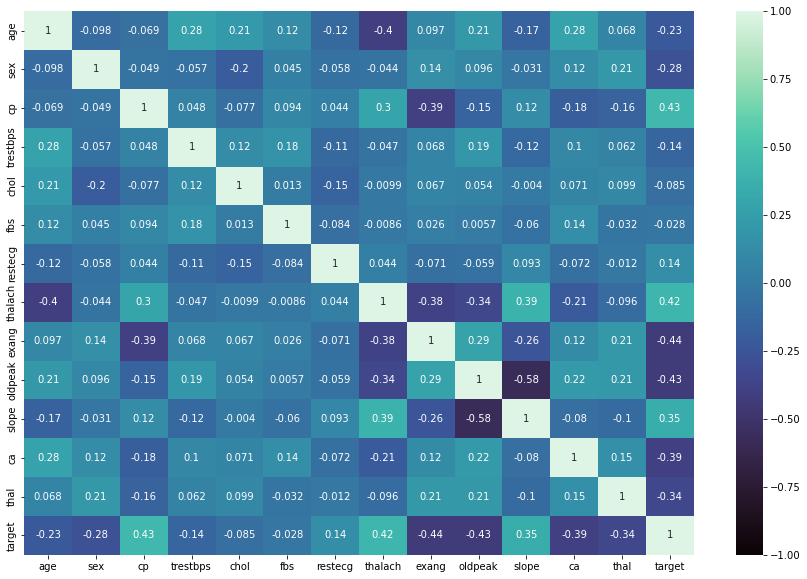

In [7]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),
            vmin=-1,
            cmap='mako',
            annot=True);

## Checking the quantity of data we have for each possible result

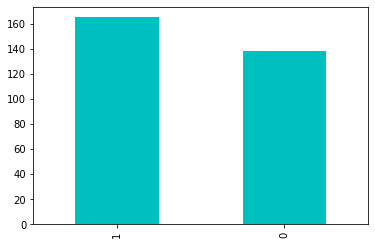

In [8]:
p=df.target.value_counts().plot(kind='bar', color='c')

## Checking for missing values

In [9]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

# Create the model 

## Preprocessing data

In [10]:
X = df.drop('target', axis=1)
y = df['target']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

## Normalize data

In [11]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

## Applying Principal Component Analysis (PCA) to find the 'explained variance ratio'

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

pca.explained_variance_ratio_

array([0.20650165, 0.1240985 , 0.09998057, 0.08807527, 0.08066108,
       0.07725931, 0.06893169, 0.06117669, 0.0568642 , 0.04321032,
       0.03433394, 0.03055737, 0.02834941])

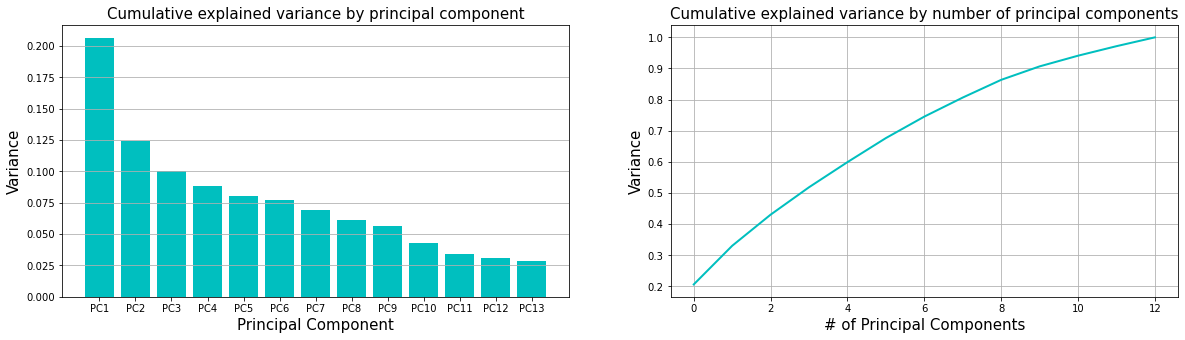

In [13]:
#Create dataframe from PCA
df_variance = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4', 'PC5', 'PC6', 'PC7', 'PC8','PC9', 'PC10', 'PC11', 'PC12', 'PC13']})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
#bar chart
ax1.bar('PC','var', data=df_variance, color='c')
ax1.set_title('Cumulative explained variance by principal component', size=15)
ax1.set_xlabel('Principal Component', fontsize = 15)
ax1.set_ylabel('Variance', fontsize = 15);
ax1.grid(axis='y')

# plot
ax2.plot(pca.explained_variance_ratio_.cumsum(), lw=2, color='c')
ax2.set_title('Cumulative explained variance by number of principal components', size=15)
ax2.set_xlabel('# of Principal Components', fontsize = 15)
ax2.set_ylabel('Variance', fontsize = 15)
ax2.grid()


### PC10-PC13 have the lowest explained variance ratios; however, we will not eliminate them as the benefit on such a small scale is miniscule, if any.

# Training the model with Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', penalty='l2',C = 0.01,random_state = 15)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

## Save Model

In [19]:
pickle.dump(lr, open('lr_model.pkl', 'wb'))

## Accuracy check

In [20]:
from sklearn.metrics import accuracy_score

print('Accuracy: ' , round(accuracy_score(y_test, y_pred)*100, 2),'%')

Accuracy:  82.42 %


## Confusion matrix

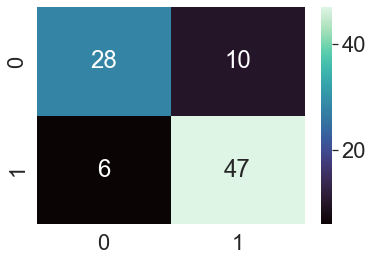

In [21]:
from sklearn.metrics import confusion_matrix
sns.set(font_scale=2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='mako')
plt.show()

# Develop the web application

In [22]:
import pandas as pd
import pickle
import dash
import dash_auth
from dash import dash_table
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

df = pd.read_csv("heart.csv")

# Load Model
lr = pickled_model = pickle.load(open('lr_model.pkl', 'rb'))

# CSS stylesheet
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# Username and Password
VALID_USERNAME_PASSWORD_PAIRS = {
    'username': 'password'
}

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
server = app.server

# Authentication
auth = dash_auth.BasicAuth(
    app,
    VALID_USERNAME_PASSWORD_PAIRS
)

# Create Table
table = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='lightgrey',
                align='left'),
    cells=dict(values=[df.age, df.sex, df.cp, df.trestbps, df.chol, df.fbs, df.restecg,
                      df.thalach, df.exang, df.oldpeak, df.slope, df.ca, df.thal, df.target],
               fill_color='whitesmoke',
               align='left'))
])
    
# Create Histogram
df['Positive'] = df[df['target'] == 1]['age']
df['Negative'] = df[df['target'] == 0]['age']
histogram = df[['Negative', 'Positive']].iplot(kind='histogram',
                                               barmode='stack',
                                               bins=20,
                                               theme='pearl',
                                               title='Heart Disease by Age Group',
                                               xTitle='Ages',
                                               yTitle='Count',
                                               asFigure=True)
# Create Heatmap
df = pd.read_csv("heart.csv")
fig = px.imshow(df.corr(), text_auto=True, aspect="auto", color_continuous_scale='RdBu_r') 

app.layout = html.Div([
    dcc.Tabs([
        # TAB 1
        dcc.Tab(label='Heart Disease Prediction Tool', children=[
            html.H1('Heart Disease Prediction Tool', style={'textAlign': 'center', 'margin-bottom': '-4px'}),
            html.P('Please enter the information below:', style={'textAlign': 'center'}),

            html.H5('Age:', style={'textAlign': 'center'}),
            # Age - Slider
            dcc.Slider(
                id='age',
                min=0,
                max=120,
                step=1,
                value=60,
                tooltip={"placement": "bottom", "always_visible": True},
            ),

            html.H5('Sex:', style={'textAlign': 'center'}),
            # Sex - Dropdown
            dcc.Dropdown(
                id='sex',
                options=[
                    {'label': 'Male', 'value': '1'},
                    {'label': 'Female', 'value': '0'},
                ],
                searchable=False,
                style={"width": "50%", "margin": 'auto'}
            ),

            html.H5('Chest Pain:', style={'textAlign': 'center'}),
            # Chest Pain - Dropdown
            dcc.Dropdown(
                id='cp',
                options=[
                    {'label': 'Typical agina', 'value': '0'},
                    {'label': 'Atypical agina', 'value': '1'},
                    {'label': 'Non-anginal pain', 'value': '2'},
                    {'label': 'Asymptomatic', 'value': '3'},
                ],
                searchable=False,
                style={"width": "50%", "margin": 'auto'}
            ),

            html.H5('Resting Blood Pressure (mm Hg):', style={'textAlign': 'center'}),
            # Resting Blood Pressure - Slider
            dcc.Slider(
                id='trestbps',
                min=0,
                max=250,
                step=1,
                value=125,
                tooltip={"placement": "bottom", "always_visible": True},
            ),

            html.H5('Serum Cholestoral (mg/dl):', style={'textAlign': 'center'}),
            # Serum Cholestoral - Slider
            dcc.Slider(
                id='chol',
                min=0,
                max=400,
                step=1,
                value=200,
                tooltip={"placement": "bottom", "always_visible": True},
            ),

            html.H5('Fasting Blood Sugar > 120 mg/dl:', style={'textAlign': 'center'}),
            # Fasting Blood Sugar - Dropdown
            dcc.Dropdown(
                id='fbs',
                options=[
                    {'label': 'True', 'value': '1'},
                    {'label': 'False', 'value': '0'},
                ],
                searchable=False,
                style={"width": "50%", "margin": 'auto'},
            ),

            html.H5('Resting ECG Results:', style={'textAlign': 'center'}),
            # Resting ECG Results - Dropdown
            dcc.Dropdown(
                id='restecg',
                options=[
                    {'label': 'Normal', 'value': '0'},
                    {
                        'label': 'Having ST-T Wave Abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)',
                        'value': '1'},
                    {'label': 'Showing Probable or Definite Left Ventricular Hypertrophy by Estes\' Criteria',
                     'value': '2'},
                ],
                searchable=False,
                style={"width": "50%", "margin": 'auto'},
            ),

            html.H5('Maximum Heart Rate Achieved:', style={'textAlign': 'center'}),
            # Maximum Heart Rate Achieved - Slider
            dcc.Slider(
                id='thalach',
                min=0,
                max=300,
                step=1,
                value=150,
                tooltip={"placement": "bottom", "always_visible": True},
            ),

            html.H5('Exercise Induced Angina:', style={'textAlign': 'center'}),
            # Exercise Induced Angina - Dropdown
            dcc.Dropdown(
                id='exang',
                options=[
                    {'label': 'True', 'value': '1'},
                    {'label': 'False', 'value': '0'},
                ],
                searchable=False,
                style={"width": "50%", "margin": 'auto'},
            ),

            html.H5('ST Depression Induced by Exercise Relative to Rest:', style={'textAlign': 'center'}),
            # MST Depression Induced by Exercise Relative to Rest - Slider
            dcc.Slider(
                id='oldpeak',
                min=0,
                max=6,
                step=0.1,
                value=3,
                tooltip={"placement": "bottom", "always_visible": True},
            ),

            html.H5('The Slope of the Peak Exercise ST Segment:', style={'textAlign': 'center'}),
            # The Slope of the Peak Exercise ST Segment - Dropdown
            dcc.Dropdown(
                id='slope',
                options=[
                    {'label': 'Upsloping', 'value': '0'},
                    {'label': 'Flat', 'value': '1'},
                    {'label': 'Downsloping', 'value': '2'},
                ],
                searchable=False,
                style={"width": "50%", "margin": 'auto'},
            ),

            html.H5('Number of Major Vessels Colored by Flourosopy:', style={'textAlign': 'center'}),
            # Number of Major Vessels Colored by Flourosopy - Slider
            dcc.Slider(
                id='ca',
                min=0,
                max=4,
                step=1,
                value=2,
                tooltip={"placement": "bottom", "always_visible": True},
            ),

            html.H5('Thal:', style={'textAlign': 'center'}),
            # Thal - Dropdown
            dcc.Dropdown(
                id='thal',
                options=[
                    {'label': 'Normal', 'value': '2'},
                    {'label': 'Fixed Defect', 'value': '1'},
                    {'label': 'Reversable Defect', 'value': '3'},
                ],
                searchable=False,
                style={"width": "50%", "margin": 'auto'},
            ),

            # html.Button('Predict', id='predict', style={"margin":'auto', "margin-top":'10px', "display":'block'}),
            html.Div(id='output-container'),
        ]),
        # TAB 2
        dcc.Tab(label='Data Visualizations', children=[
            html.H1('Data Visualizations', style={'textAlign': 'center'}),
            # Display Table\
            dcc.Graph(figure=table),
            # Display Histogram
            dcc.Graph(figure=histogram),
            # Display Heatmap
            dcc.Graph(figure=fig)
        ])
    ])
])


@app.callback(
    Output('output-container', 'children'),
    #  Input('predict', 'n_clicks'),
    Input('age', 'value'),
    Input('sex', 'value'),
    Input('cp', 'value'),
    Input('trestbps', 'value'),
    Input('chol', 'value'),
    Input('fbs', 'value'),
    Input('restecg', 'value'),
    Input('thalach', 'value'),
    Input('exang', 'value'),
    Input('oldpeak', 'value'),
    Input('slope', 'value'),
    Input('ca', 'value'),
    Input('thal', 'value'))

def update_output(age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal):
    values = pd.DataFrame({'age': [age], 'sex': [sex], 'cp': [cp], 'trestbps': [trestbps],
                           'chol': [chol], 'fbs': [fbs], 'restecg': [restecg], 'thalach': [thalach],
                           'exang': [exang], 'oldpeak': [oldpeak], 'slope': [slope], 'ca': [ca],
                           'thal': [thal]})

    if lr.predict(values) == 1:
        return html.H5(("Heart Disease is likely. Confidence: ", str(int(lr.predict_proba(values)[:, 1] * 100)) + "%."),
                       style={'textAlign': 'center', 'color': 'red'})
    else:
        return html.H5(
            ("Heart Disease is unlikely. Confidence: ", str(int(lr.predict_proba(values)[:, 0] * 100)) + "%."),
            style={'textAlign': 'center', 'color': 'green'})

    
if __name__ == '__main__':
    app.run_server(debug=False)


Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
